# Plot Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

### Metadata

In [3]:
# load metadata generated from metadata.ipynb
metadata = pd.read_csv('/scratch/rn2214/source-separation/data/binaural_musdb18/random/metadata.csv', index_col=0)

In [4]:
metadata.rename(columns={'random_angle': 'binaural'}, inplace=True)
metadata = metadata.melt(id_vars=['title', 'source'],
                         var_name='dataset', value_name='angle')

In [5]:
STEMS = ['bass', 'drums', 'other', 'vocals']
DATASETS = ['binaural', 'stereo']
MODELS = ['ht-demucs', 'bs-roformer', 'scnet', 'bi-scnet']

### Plot Parameters

In [6]:
# make directory to save plots to
PLOT_DIR = '../data/plots/binaural_scnet'
os.makedirs(PLOT_DIR, exist_ok=True)

# whether to save plots
SAVE_PLOT = True

In [7]:
# use an accessible color palette
plt.style.use('petroff10') # 'tableau-colorblind10'

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

DATASET_PALETTE = dict(zip(DATASETS, COLORS[:2]))
STEM_PALETTE = dict(zip(STEMS, COLORS[2:6]))
MODEL_PALETTE = dict(zip(MODELS, COLORS[6:]))

## SPAUQ: Spatial Audio Quality Evaluation

In [8]:
OUTLIERS = False
FIG_SIZE = (10, 3)

### Data

In [9]:
# load computed metrics
ht_binaural_df = pd.read_csv('../results/spauq/spauq_2025-03-23_htdemucs_ft_binaural.csv')
ht_stereo_df = pd.read_csv('../results/spauq/spauq_2025-03-23_htdemucs_ft_stereo.csv')

bsr_binaural_df = pd.read_csv('../results/spauq/spauq_2025-07-30_bs_roformer_binaural.csv')
bsr_stereo_df = pd.read_csv('../results/spauq/spauq_2025-07-30_bs_roformer_stereo.csv')

scn_binaural_df = pd.read_csv('../results/spauq/spauq_2025-08-11_scnet_binaural.csv')
scn_stereo_df = pd.read_csv('../results/spauq/spauq_2025-08-11_scnet_stereo.csv')

bscn_binaural_df = pd.read_csv('../results/spauq/spauq_2025-08-18_binscnet.csv')

In [10]:
ht_binaural_df['dataset'] = 'ht-demucs_binaural'
ht_stereo_df['dataset'] = 'ht-demucs_stereo'

bsr_binaural_df['dataset'] = 'bs-roformer_binaural'
bsr_stereo_df['dataset'] = 'bs-roformer_stereo'

scn_binaural_df['dataset'] = 'scnet_binaural'
scn_stereo_df['dataset'] = 'scnet_stereo'

bscn_binaural_df['dataset'] = 'bi-scnet_binaural'

In [11]:
all_models = pd.concat([ht_binaural_df, ht_stereo_df,
                        bsr_binaural_df, bsr_stereo_df,
                        scn_binaural_df, scn_stereo_df,
                        bscn_binaural_df],
                       ignore_index=True)

In [12]:
all_models['model'] = all_models['dataset'].apply(lambda x: x.split('_')[0])
all_models['dataset'] = all_models['dataset'].apply(lambda x: x.split('_')[-1])

### By Model (Overall)

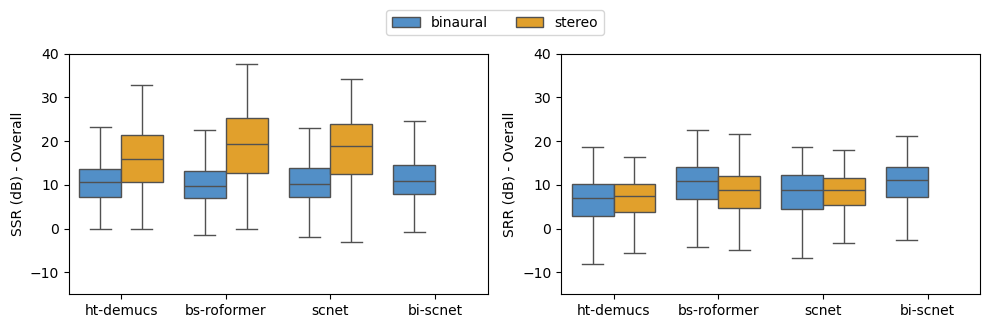

In [13]:
fig, axs = plt.subplots(1, 2, figsize=FIG_SIZE, tight_layout=True)

sns.boxplot(x='model', y='SSR', hue='dataset', data=all_models, ax=axs[0],
            palette=DATASET_PALETTE, showfliers=OUTLIERS)
sns.boxplot(x='model', y='SRR', hue='dataset', data=all_models, ax=axs[1],
            palette=DATASET_PALETTE, showfliers=OUTLIERS)

axs[0].set(ylabel='SSR (dB) - Overall', xlabel='', ylim=[-15, 40])
axs[1].set(ylabel='SRR (dB) - Overall', xlabel='', ylim=[-15, 40])

h, l = axs[0].get_legend_handles_labels()
l = ['binaural', 'stereo']

for a in axs:
    a.legend().remove()

fig.legend(h, l, loc='upper center', fontsize=10, ncols=3, bbox_to_anchor=(0.5, 1.1))
if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'spauq_model_overall.pdf'), bbox_inches='tight')
plt.show()

### By Model (By Source)

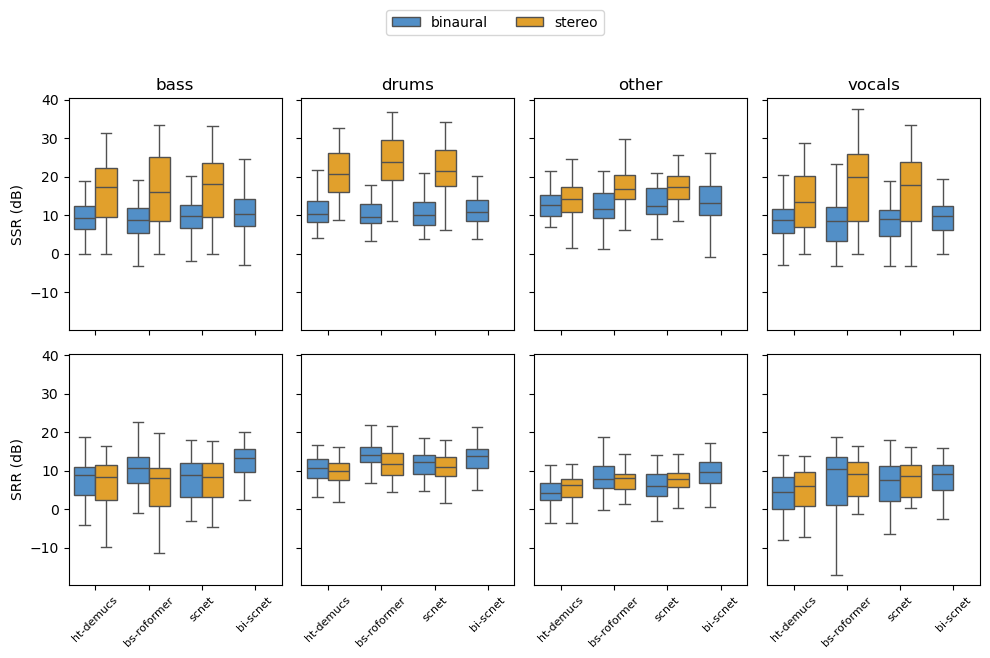

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(10, 6), tight_layout=True,
                        sharex=True, sharey=True)

x_labels = ['ht-demucs', 'bs-roformer', 'scnet', 'bi-scnet']

for i in range(len(STEMS)):
    stem_df = all_models[all_models['source'] == STEMS[i]]
    
    sns.boxplot(x='model', y='SSR', hue='dataset', data=stem_df, ax=axs[0][i],
                palette=DATASET_PALETTE, showfliers=OUTLIERS)
    sns.boxplot(x='model', y='SRR', hue='dataset', data=stem_df, ax=axs[1][i],
                palette=DATASET_PALETTE, showfliers=OUTLIERS)
    
    axs[0][i].set(ylabel='SSR (dB)', xlabel='')
    axs[1][i].set(ylabel='SRR (dB)', xlabel='')
    axs[0][i].set_title(STEMS[i])

    axs[1][i].set_xticks(x_labels)
    axs[1][i].set_xticklabels(x_labels, fontsize=8, rotation=45)

h, l = axs[0][0].get_legend_handles_labels()
l = ['binaural', 'stereo']

for ax in axs.flatten():
    ax.legend().remove()

fig.legend(h, l, loc='upper center', fontsize=10, ncols=2, bbox_to_anchor=(0.5, 1.1))
if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'spauq_model_source.pdf'), bbox_inches='tight')
plt.show()

### Angle Bins

In [15]:
OUTLIERS = False
FIG_SIZE = (6, 4)

In [16]:
merged_df = pd.merge(metadata, all_models, how='inner')
b = np.arange(-90, 91, 30)

# use these labels if you want the direction of the x-axis
# to match the physical placement
# b_labels = ['[-60°, -90°]', '[-30°, -60°)', '[0°, -30°)',
#             '[30°, 0°)', '[60°, 30°)', '[90°, 60°)']

b_labels = ['[-90°, -60°]', '(-60°, -30°]', '(-30°, 0°]',
            '(0°, 30°]', '(30°, 60°]', '(60°, 90°]']
merged_df['bins_ordered'] = pd.cut(merged_df['angle'], bins=b,
                                   include_lowest=True, labels=b_labels)

# reorder if you want the direction of the x-axis
# to match the physical placement
# merged_df['bins_ordered'] = merged_df.bins.cat.reorder_categories(merged_df.bins.cat.categories[::-1], ordered=True)

In [17]:
spauq_angle_df = merged_df.copy()

### By Angle (Overall by Model)

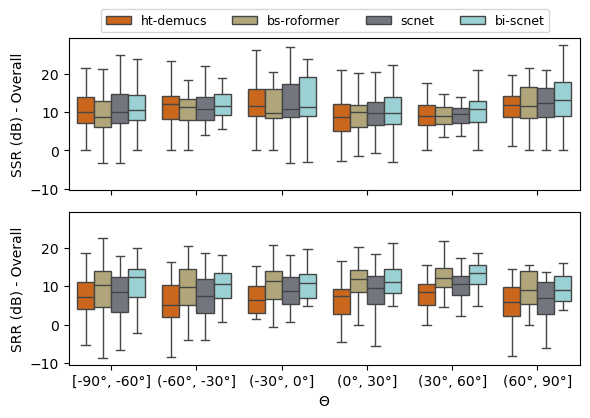

In [18]:
fig, ax = plt.subplots(2, 1, figsize=FIG_SIZE, tight_layout=True,
                       sharex=True, sharey=True)

sns.boxplot(x='bins_ordered', y='SSR', hue='model', data=merged_df,
            ax=ax[0], palette=MODEL_PALETTE, showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='SRR', hue='model', data=merged_df,
            ax=ax[1], palette=MODEL_PALETTE, showfliers=OUTLIERS)

for a in ax:
    a.legend().remove()

h, l = ax[0].get_legend_handles_labels()

ax[0].set(ylabel='SSR (dB) - Overall', xlabel='$\Theta$')
ax[1].set(ylabel='SRR (dB) - Overall', xlabel='$\Theta$')

fig.legend(h, l, loc='upper center', fontsize=9, ncols=5, bbox_to_anchor=(0.55, 1.05))
if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'spauq_model_angle.pdf'), bbox_inches='tight')
plt.show()

### By Angle (Overall by Source)

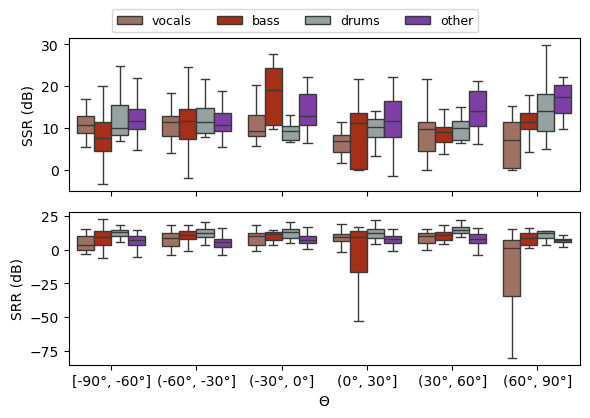

In [19]:
fig, ax = plt.subplots(2, 1, figsize=FIG_SIZE, tight_layout=True,
                       sharex=True, sharey=False)

sns.boxplot(x='bins_ordered', y='SSR', hue='source', data=merged_df,
            palette=STEM_PALETTE, ax=ax[0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='SRR', hue='source', data=merged_df,
            palette=STEM_PALETTE, ax=ax[1], showfliers=OUTLIERS)

h, l = ax[0].get_legend_handles_labels()

for a in ax:
    a.legend().remove()

ax[0].set(ylabel='SSR (dB)', xlabel='$\Theta$')
ax[1].set(ylabel='SRR (dB)', xlabel='$\Theta$')

fig.legend(h, l, loc='upper center', fontsize=9, ncols=4, bbox_to_anchor=(0.5, 1.05))
if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'spauq_source_angle.pdf'), bbox_inches='tight')
plt.show()

### By Angle (Model by Source)

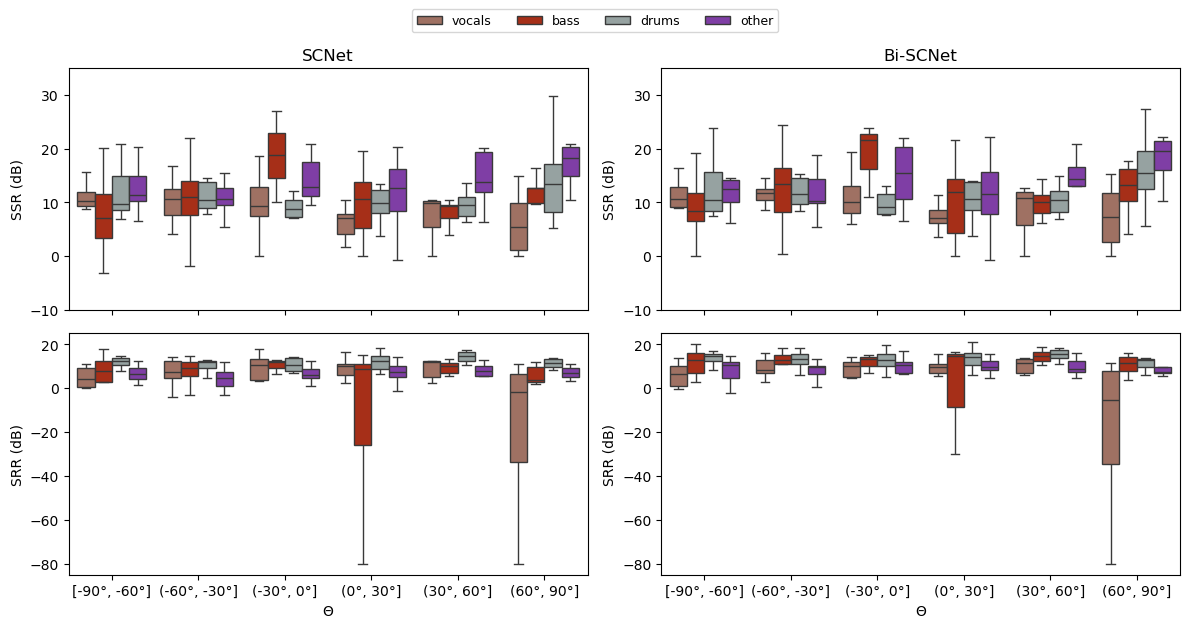

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6), tight_layout=True,
                       sharex=True, sharey=False)

sns.boxplot(x='bins_ordered', y='SSR', hue='source', data=merged_df[merged_df['model'] == 'scnet'],
            palette=STEM_PALETTE, ax=ax[0][0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='SRR', hue='source', data=merged_df[merged_df['model'] == 'scnet'],
            palette=STEM_PALETTE, ax=ax[1][0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='SSR', hue='source', data=merged_df[merged_df['model'] == 'bi-scnet'],
            palette=STEM_PALETTE, ax=ax[0][1], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='SRR', hue='source', data=merged_df[merged_df['model'] == 'bi-scnet'],
            palette=STEM_PALETTE, ax=ax[1][1], showfliers=OUTLIERS)

h, l = ax[0][0].get_legend_handles_labels()

for row in ax:
    for col in row:
        col.legend().remove()

lims = [[-10, 35], [-85, 25]]
titles = ['SCNet', 'Bi-SCNet']
for j in range(2):
    ax[0][j].set(ylabel='SSR (dB)', xlabel='$\Theta$', ylim=lims[0], title=titles[j])
    ax[1][j].set(ylabel='SRR (dB)', xlabel='$\Theta$', ylim=lims[1])


fig.legend(h, l, loc='upper center', fontsize=9, ncols=4, bbox_to_anchor=(0.5, 1.05))
if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'spauq_source_angle_scnet.pdf'), bbox_inches='tight')
plt.show()

### By Angle (Overall)

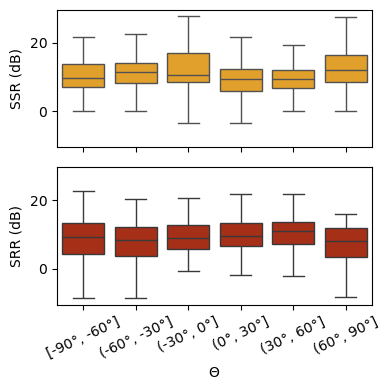

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), tight_layout=True,
                       sharex=True, sharey=True)

sns.boxplot(x='bins_ordered', y='SSR', color=COLORS[1],
            data=merged_df, ax=ax[0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='SRR', color=COLORS[2],
            data=merged_df, ax=ax[1], showfliers=OUTLIERS)

ax[0].set(ylabel='SSR (dB)', xlabel='$\Theta$')
ax[1].set(ylabel='SRR (dB)', xlabel='$\Theta$')

ax[1].tick_params(axis='x', rotation=25)

if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'spauq_source_angle.pdf'), bbox_inches='tight')
plt.show()

## $\Delta$ITD & $\Delta$ILD

### Data

In [22]:
ht_binaural_df = pd.read_csv('../results/interaural/interaural_2025-06-26_htdemucs_ft_binaural.csv')
ht_stereo_df = pd.read_csv('../results/interaural/interaural_2025-06-26_htdemucs_ft_stereo.csv')

bsr_binaural_df = pd.read_csv('../results/interaural/interaural_2025-07-30_bs_roformer_binaural.csv')
bsr_stereo_df = pd.read_csv('../results/interaural/interaural_2025-07-30_bs_roformer_stereo.csv')

scn_binaural_df = pd.read_csv('../results/interaural/interaural_2025-08-11_scnet_binaural.csv')
scn_stereo_df = pd.read_csv('../results/interaural/interaural_2025-08-11_scnet_stereo.csv')

bscn_binaural_df = pd.read_csv('../results/interaural/interaural_2025-08-18_binscnet.csv')

In [23]:
ht_binaural_df['dataset'] = 'ht-demucs_binaural'
ht_stereo_df['dataset'] = 'ht-demucs_stereo'

bsr_binaural_df['dataset'] = 'bs-roformer_binaural'
bsr_stereo_df['dataset'] = 'bs-roformer_stereo'

scn_binaural_df['dataset'] = 'scnet_binaural'
scn_stereo_df['dataset'] = 'scnet_stereo'

bscn_binaural_df['dataset'] = 'bi-scnet_binaural'

In [24]:
all_models = pd.concat([ht_binaural_df, ht_stereo_df,
                        bsr_binaural_df, bsr_stereo_df,
                        scn_binaural_df, scn_stereo_df,
                        bscn_binaural_df],
                       ignore_index=True)

In [25]:
all_models['model'] = all_models['dataset'].apply(lambda x: x.split('_')[0])
all_models['dataset'] = all_models['dataset'].apply(lambda x: x.split('_')[-1])

### By Model (Overall)

In [26]:
OUTLIERS = False
FIG_SIZE = (10, 3)

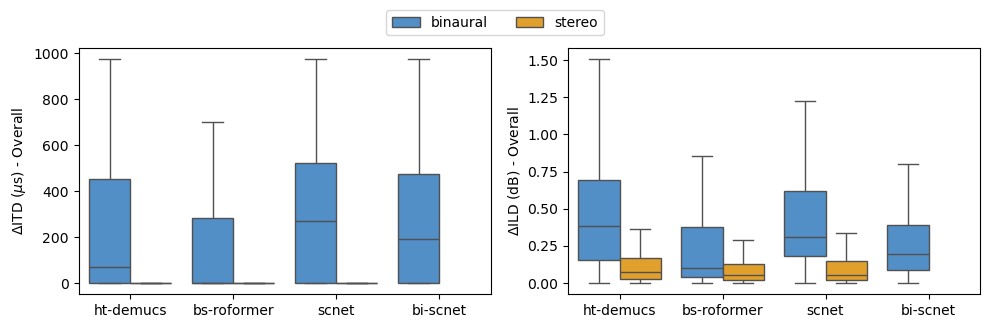

In [27]:
fig, axs = plt.subplots(1, 2, figsize=FIG_SIZE, tight_layout=True)
sns.boxplot(x='model', y='diff_ITD', hue='dataset', data=all_models,
            ax=axs[0], palette=DATASET_PALETTE, showfliers=OUTLIERS)
sns.boxplot(x='model', y='diff_ILD', hue='dataset', data=all_models,
            ax=axs[1], palette=DATASET_PALETTE, showfliers=OUTLIERS)

axs[0].set(ylabel='$\Delta$ITD ($\mu$s) - Overall', xlabel='')
axs[1].set(ylabel='$\Delta$ILD (dB) - Overall', xlabel='')

h, l = axs[0].get_legend_handles_labels()
l = ['binaural', 'stereo']

for a in axs:
    a.legend().remove()

fig.legend(h, l, loc='upper center', fontsize=10, ncols=3, bbox_to_anchor=(0.5, 1.1))
if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'itdild_model_overall.pdf'), bbox_inches='tight')
plt.show()

### By Model (By Source)

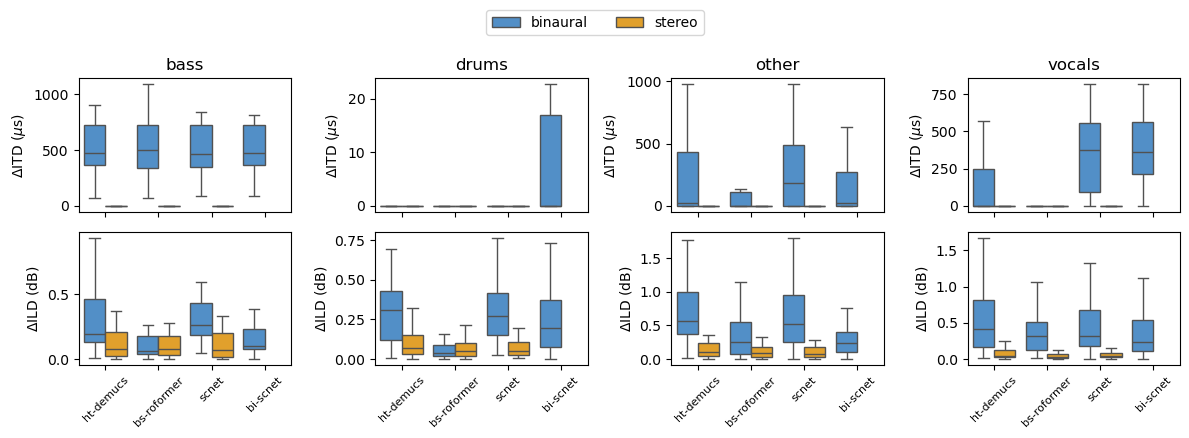

In [28]:
fig, axs = plt.subplots(2, 4, figsize=(12, 4),
                        tight_layout=True, sharex=True)

x_labels = ['ht-demucs', 'bs-roformer', 'scnet', 'bi-scnet']

for i in range(len(STEMS)):
    stem_df = all_models[all_models['source'] == STEMS[i]]
    
    sns.boxplot(x='model', y='diff_ITD', hue='dataset', data=stem_df,
                ax=axs[0][i], palette=DATASET_PALETTE, showfliers=OUTLIERS)
    sns.boxplot(x='model', y='diff_ILD', hue='dataset', data=stem_df,
                ax=axs[1][i], palette=DATASET_PALETTE, showfliers=OUTLIERS)
    
    axs[0][i].set(ylabel='$\Delta$ITD ($\mu$s)', xlabel='')
    axs[1][i].set(ylabel='$\Delta$ILD (dB)', xlabel='')
    axs[0][i].set_title(STEMS[i])

    axs[1][i].set_xticks(x_labels)
    axs[1][i].set_xticklabels(x_labels, fontsize=8, rotation=45)

h, l = axs[0][0].get_legend_handles_labels()
l = ['binaural', 'stereo']

for ax in axs.flatten():
    ax.legend().remove()

fig.legend(h, l, loc='upper center', fontsize=10, ncols=3, bbox_to_anchor=(0.5, 1.1))
if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'itdild_model_source.pdf'), bbox_inches='tight')
plt.show()

### Angle Bins

In [29]:
OUTLIERS = False
FIG_SIZE = (6, 4)

In [30]:
merged_df = pd.merge(metadata, all_models, how='inner')
b = np.arange(-90, 91, 30)

# use these labels if you want the direction of the x-axis
# to match the physical placement
# b_labels = ['[-60°, -90°]', '[-30°, -60°)', '[0°, -30°)',
#             '[30°, 0°)', '[60°, 30°)', '[90°, 60°)']

b_labels = ['[-90°, -60°]', '(-60°, -30°]', '(-30°, 0°]',
            '(0°, 30°]', '(30°, 60°]', '(60°, 90°]']
merged_df['bins_ordered'] = pd.cut(merged_df['angle'], bins=b,
                                   include_lowest=True, labels=b_labels)

# reorder if you want the direction of the x-axis
# to match the physical placement
# merged_df['bins_ordered'] = merged_df.bins.cat.reorder_categories(merged_df.bins.cat.categories[::-1], ordered=True)

In [31]:
delta_angle_df = merged_df.copy()

### By Angle (Overall by Model)

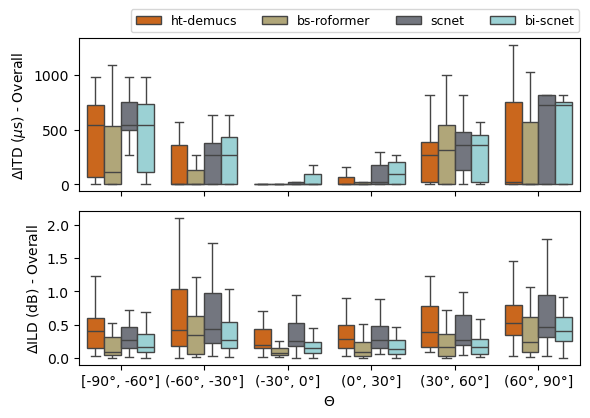

In [32]:
fig, axs = plt.subplots(2, 1, figsize=FIG_SIZE, tight_layout=True,
                        sharex=True, sharey=False)

sns.boxplot(x='bins_ordered', y='diff_ITD', hue='model', data=merged_df,
            ax=axs[0], palette=MODEL_PALETTE, showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ILD', hue='model', data=merged_df,
            ax=axs[1], palette=MODEL_PALETTE, showfliers=OUTLIERS)

h, l = axs[0].get_legend_handles_labels()

for ax in axs:
    ax.legend().remove()

axs[0].set(ylabel='$\Delta$ITD ($\mu$s) - Overall', xlabel='$\Theta$')
axs[1].set(ylabel='$\Delta$ILD (dB) - Overall', xlabel='$\Theta$')

fig.legend(h, l, loc='upper center', fontsize=9, ncols=4, bbox_to_anchor=(0.6, 1.05))
if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'itdild_model_angle.pdf'), bbox_inches='tight')
plt.show()

### By Angle (Overall by Source)

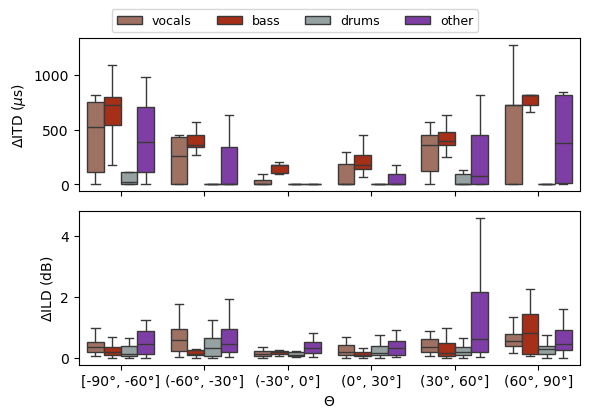

In [33]:
fig, axs = plt.subplots(2, 1, figsize=FIG_SIZE, tight_layout=True,
                        sharex=True, sharey=False)

sns.boxplot(x='bins_ordered', y='diff_ITD', hue='source', data=merged_df,
            palette=STEM_PALETTE, ax=axs[0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ILD', hue='source', data=merged_df,
            palette=STEM_PALETTE, ax=axs[1], showfliers=OUTLIERS)

h, l = axs[0].get_legend_handles_labels()

for ax in axs:
    ax.legend().remove()

axs[0].set(ylabel='$\Delta$ITD ($\mu$s)', xlabel='$\Theta$')
axs[1].set(ylabel='$\Delta$ILD (dB)', xlabel='$\Theta$')

fig.legend(h, l, loc='upper center', fontsize=9, ncols=4, bbox_to_anchor=(0.5, 1.05))
if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'itdild_source_angle.pdf'), bbox_inches='tight')
plt.show()

### By Angle (Model by Source)

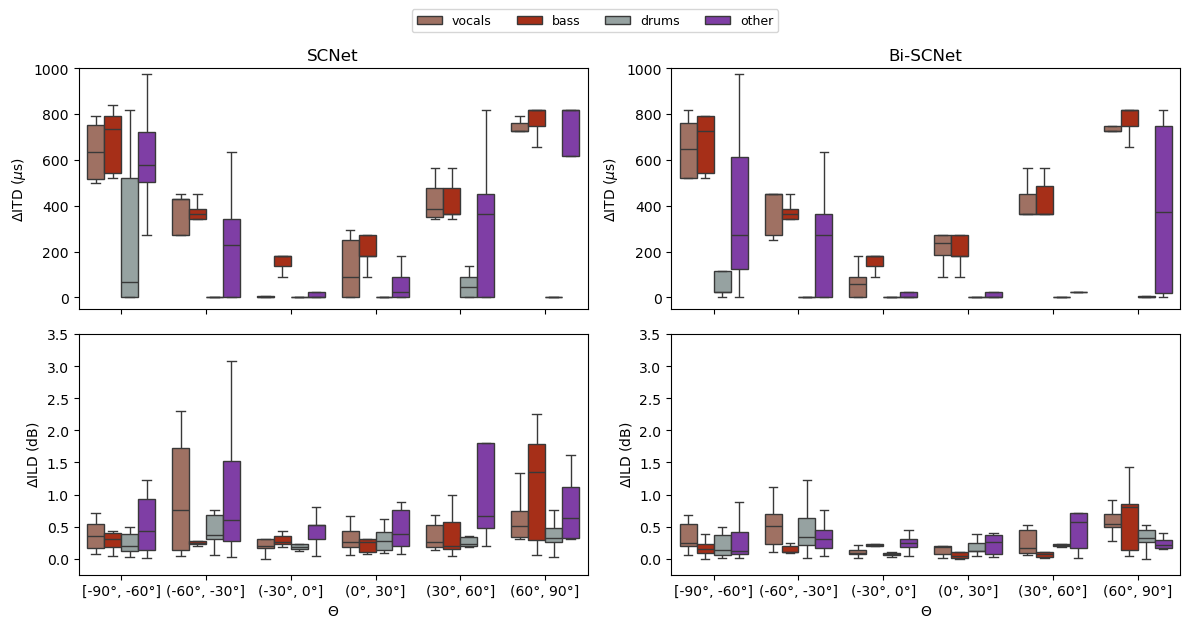

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6), tight_layout=True,
                       sharex=True, sharey=False)

sns.boxplot(x='bins_ordered', y='diff_ITD', hue='source', data=merged_df[merged_df['model'] == 'scnet'],
            palette=STEM_PALETTE, ax=ax[0][0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ILD', hue='source', data=merged_df[merged_df['model'] == 'scnet'],
            palette=STEM_PALETTE, ax=ax[1][0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ITD', hue='source', data=merged_df[merged_df['model'] == 'bi-scnet'],
            palette=STEM_PALETTE, ax=ax[0][1], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ILD', hue='source', data=merged_df[merged_df['model'] == 'bi-scnet'],
            palette=STEM_PALETTE, ax=ax[1][1], showfliers=OUTLIERS)

h, l = ax[0][0].get_legend_handles_labels()

for row in ax:
    for col in row:
        col.legend().remove()

lims = [[-50, 1000], [-0.25, 3.5]]
titles = ['SCNet', 'Bi-SCNet']
for j in range(2):
    ax[0][j].set(ylabel='$\Delta$ITD ($\mu$s)', xlabel='$\Theta$', ylim=lims[0], title=titles[j])
    ax[1][j].set(ylabel='$\Delta$ILD (dB)', xlabel='$\Theta$', ylim=lims[1])


fig.legend(h, l, loc='upper center', fontsize=9, ncols=4, bbox_to_anchor=(0.5, 1.05))
if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'itdild_source_angle_scnet.pdf'), bbox_inches='tight')
plt.show()

### By Angle (Overall)

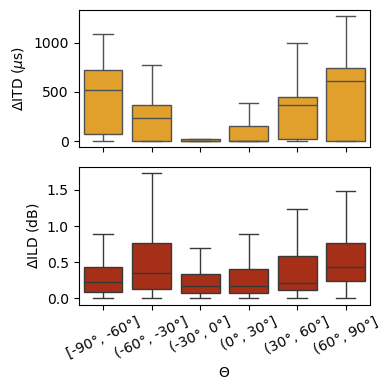

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), tight_layout=True,
                       sharex=True, sharey=False)

sns.boxplot(x='bins_ordered', y='diff_ITD', color=COLORS[1], data=merged_df,
            ax=ax[0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ILD', color=COLORS[2], data=merged_df,
            ax=ax[1], showfliers=OUTLIERS)

ax[0].set(ylabel='$\Delta$ITD ($\mu$s)', xlabel='$\Theta$')
ax[1].set(ylabel='$\Delta$ILD (dB)', xlabel='$\Theta$')

ax[1].tick_params(axis='x', rotation=25)

if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'itdild_angle.pdf'), bbox_inches='tight')
plt.show()

## All Spatial Metrics

In [36]:
all_spatial = pd.merge(spauq_angle_df, delta_angle_df, how='inner')

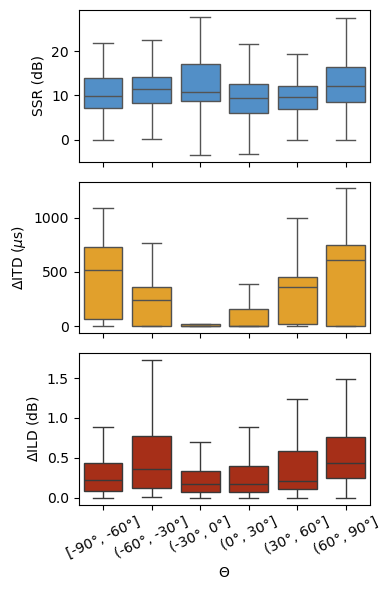

In [37]:
fig, ax = plt.subplots(3, 1, figsize=(4, 6), tight_layout=True,
                       sharex=True, sharey=False)

sns.boxplot(x='bins_ordered', y='SSR', color=COLORS[0], data=all_spatial,
            ax=ax[0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ITD', color=COLORS[1], data=all_spatial,
            ax=ax[1], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ILD', color=COLORS[2], data=all_spatial,
            ax=ax[2], showfliers=OUTLIERS)

ax[0].set(ylabel='SSR (dB)', xlabel='$\Theta$')
ax[1].set(ylabel='$\Delta$ITD ($\mu$s)', xlabel='$\Theta$')
ax[2].set(ylabel='$\Delta$ILD (dB)', xlabel='$\Theta$')

ax[2].tick_params(axis='x', rotation=25)

if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'spatial_angle.pdf'), bbox_inches='tight')
plt.show()

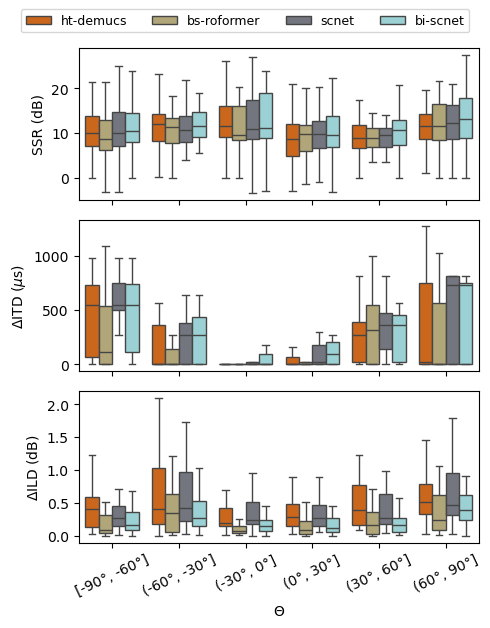

In [38]:
fig, ax = plt.subplots(3, 1, figsize=(5, 6), tight_layout=True,
                       sharex=True, sharey=False)

sns.boxplot(x='bins_ordered', y='SSR', hue='model', palette=MODEL_PALETTE,
            data=all_spatial, ax=ax[0], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ITD', hue='model', palette=MODEL_PALETTE,
            data=all_spatial, ax=ax[1], showfliers=OUTLIERS)
sns.boxplot(x='bins_ordered', y='diff_ILD', hue='model', palette=MODEL_PALETTE,
            data=all_spatial, ax=ax[2], showfliers=OUTLIERS)

h, l = ax[0].get_legend_handles_labels()

for a in ax:
    a.legend().remove()

ax[0].set(ylabel='SSR (dB)', xlabel='$\Theta$')
ax[1].set(ylabel='$\Delta$ITD ($\mu$s)', xlabel='$\Theta$')
ax[2].set(ylabel='$\Delta$ILD (dB)', xlabel='$\Theta$')

ax[2].tick_params(axis='x', rotation=25)

fig.legend(h, l, loc='upper center', fontsize=9, ncols=5, bbox_to_anchor=(0.5, 1.05))

if SAVE_PLOT:
    plt.savefig(os.path.join(PLOT_DIR, 'spatial_angle_model.pdf'), bbox_inches='tight')
plt.show()